In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import permutation_importance
import tldextract
import matplotlib.pyplot as plt


#загрузка и предобработка данных

data = pd.read_csv("Malicious-URLs.csv")

#удаление дубликатов
data = data.drop_duplicates(subset="url")

#очистка URL
data["url"] = data["url"].str.lower().str.strip()
data

,count,url,label
0,0,br-icloud.com.br,phishing
1,1,mp3raid.com/music/krizz_kaliko.html,benign
2,2,bopsecrets.org/rexroth/cr/1.htm,benign
3,3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...,...
14995,14995,fortdefianceind.com/,benign
14996,14996,bookrags.com/lens/go.php?u=hannah_webster_foster,benign
14997,14997,burbankairport.com/parking/buses-trains.html,benign
14998,14998,http://otomoto.pl/oferta/subaru-outback-legacy...,benign


In [2]:
#извлечение признаков
def extract_features(url):
    features = {}
    try:
        #лексические признаки
        features["length"] = len(url)
        features["num_special_chars"] = sum(url.count(c) for c in ['@', '%', '//'])
        
        #анализ домена
        ext = tldextract.extract(url)
        features["subdomain_count"] = len(ext.subdomain.split('.')) if ext.subdomain else 0
        features["has_ip"] = 1 if any(part.isdigit() for part in ext.domain.split('.')) else 0
        
        #семантические признаки
        keywords = ['login', 'admin', 'exe', 'php', 'config']
        features["keyword_count"] = sum(1 for kw in keywords if kw in url)
        
        return features
    except:
        return None

#применение функции и фильтрация ошибок
features = data["url"].apply(extract_features)
valid_indices = features[features.notna()].index
data = data.loc[valid_indices]
features = features.loc[valid_indices]

#создание DataFrame с признаками
features_df = pd.DataFrame(features.tolist())
labels = data["label"].values


In [3]:
#нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)


In [4]:
#разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    labels, 
    test_size=0.2, 
    stratify=labels,
    random_state=42
)

In [7]:
#обучение KNN

#поиск лучших гиперпараметров через GridSearch
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

params = {
    "n_neighbors": [3, 5, 7, 9],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, params, cv=5, scoring="roc_auc")
grid.fit(X_train, y_train)

best_knn = grid.best_estimator_
print(f"Лучшие параметры: {grid.best_params_}")


Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 3}


In [6]:
y_pred = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:, 1]  # Вероятность класса 1

print("\nClassification Report:")
print(classification_report(y_test, y_pred))





Classification Report:
              precision    recall  f1-score   support

      benign       0.93      0.96      0.94      2199
  defacement       0.87      0.89      0.88       545
     malware       0.64      0.34      0.45        61
    phishing       0.40      0.24      0.30       182

    accuracy                           0.89      2987
   macro avg       0.71      0.61      0.64      2987
weighted avg       0.88      0.89      0.88      2987



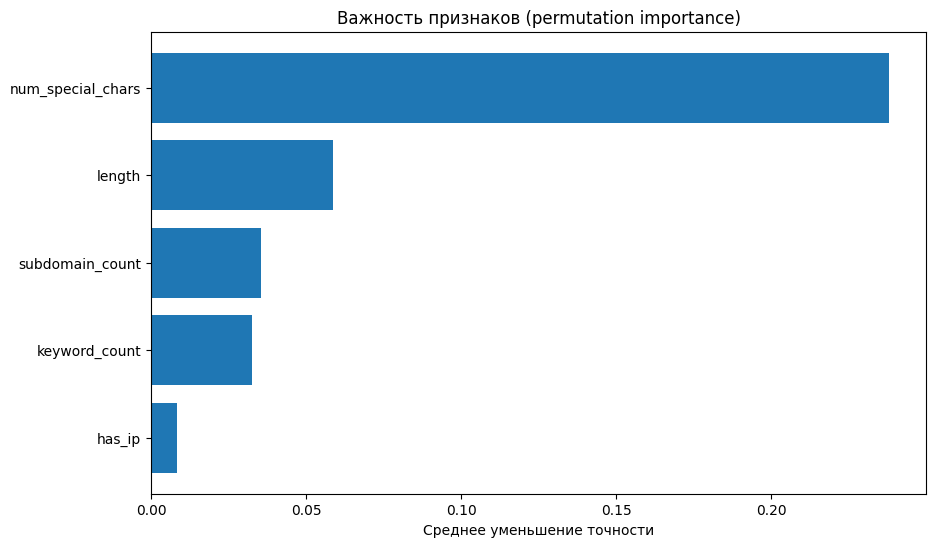

In [30]:
# Permutation Importance
result = permutation_importance(
    best_knn,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42
)

# Визуализация
plt.figure(figsize=(10, 6))
sorted_idx = result.importances_mean.argsort()
plt.barh(
    np.array(features_df.columns)[sorted_idx], 
    result.importances_mean[sorted_idx]
)
plt.title("Важность признаков (permutation importance)")
plt.xlabel("Среднее уменьшение точности")
plt.show()

In [13]:
data["label"] = data["label"].map({'defacement': 0, 'phishing': 1, 'benign': 2, 'malware': 3})
data

,count,url,label
0,0,br-icloud.com.br,1
1,1,mp3raid.com/music/krizz_kaliko.html,2
2,2,bopsecrets.org/rexroth/cr/1.htm,2
3,3,http://www.garage-pirenne.be/index.php?option=...,0
4,4,http://adventure-nicaragua.net/index.php?optio...,0
...,...,...,...
14995,14995,fortdefianceind.com/,2
14996,14996,bookrags.com/lens/go.php?u=hannah_webster_foster,2
14997,14997,burbankairport.com/parking/buses-trains.html,2
14998,14998,http://otomoto.pl/oferta/subaru-outback-legacy...,2


In [18]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = data["count"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    labels, 
    test_size=0.2, 
    stratify=labels,
    random_state=42
)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

# Sample prediction
sample = X_test.iloc[0:1]  # Keep as DataFrame to match model input format
prediction = rf_classifier.predict(sample)

# Retrieve and display the sample
sample_dict = sample.iloc[0].to_dict()
print(f"\nSample Passenger: {sample_dict}")
print(f"Predicted Survival: {'Survived' if prediction[0] == 1 else 'Did Not Survive'}")

Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

      benign       0.92      0.98      0.95      2199
  defacement       0.88      0.89      0.89       545
     malware       0.59      0.36      0.45        61
    phishing       0.55      0.17      0.26       182

    accuracy                           0.91      2987
   macro avg       0.74      0.60      0.64      2987
weighted avg       0.89      0.91      0.89      2987



AttributeError: 'numpy.ndarray' object has no attribute 'loc'